In [1]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import log_loss, make_scorer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import copy
from scipy.stats import uniform, loguniform, randint 
from tqdm import tqdm # for some reason tqdm.notebook is not working....

In [1]:
import sys

In [2]:
sys.float_info.epsilon

2.220446049250313e-16

In [2]:
SEED = 42

# should still check when to stratify
def preprocess_dataset(dataset, categorical_encoding='label', categorical_type='category'):
    dataset = copy.deepcopy(dataset) # to preserve mutable object
    # if there is no default test data
    if dataset['test_data'] is None:
        X_train, X_test, y_train, y_test = train_test_split(dataset['data'], dataset['target'], test_size=0.25,
                                                            random_state=SEED)
        dataset['data'] = X_train
        dataset['target'] = y_train
        dataset['test_data'] = X_test
        dataset['test_target'] = y_test

    # label encoding for classification task, float for regression
    if dataset['task'] == 'classification':
        label_encoder = LabelEncoder()
        dataset['label_encoder'] = label_encoder
        dataset['target_processed'] = label_encoder.fit_transform(dataset['target'])
        dataset['test_target_processed'] = label_encoder.transform(dataset['test_target'])
    else:
        dataset['label_encoder'] = None
        dataset['target_processed'] = dataset['target'].astype('float')
        dataset['test_target_processed'] = dataset['test_target'].astype('float')
    # encodes categorical data
    if categorical_encoding == 'label':
    # order of columns is preserved
        encoder = OrdinalEncoder(encoded_missing_value=-1)
        dataset['encoder'] = encoder
        dataset['data'].iloc[:,dataset['cat_features']] = encoder.fit_transform(
            dataset['data'].iloc[:,dataset['cat_features']])
        dataset['test_data'].iloc[:,dataset['cat_features']] = encoder.transform(
            dataset['test_data'].iloc[:,dataset['cat_features']])
    if categorical_encoding == 'one_hot':
    # in the case of the one hot encoding we will first have the continuous columns and after the categorical
    # (one hot encoded)
        encoder = OneHotEncoder(drop='if_binary',sparse=False) # Nan is treated as another category (extra column)
        dataset['encoder'] = encoder
        dataset['data'] = (dataset['data'].iloc[:,dataset['cont_features']]
                           .join(pd.DataFrame(encoder.fit_transform(dataset['data'].iloc[:,dataset['cat_features']]))))
        dataset['test_data'] = (dataset['test_data'].iloc[:,dataset['cont_features']]
                                .join(pd.DataFrame(encoder.transform(dataset['test_data'].
                                                                     iloc[:,dataset['cat_features']]))))
        dataset['cont_features'] = [i for i in range(len(dataset['cont_features']))]
        dataset['cat_features'] = [i for i in range(len(dataset['cont_features']),dataset['data'].shape[1])]

    # continuous features as float and categorical features as category
    # obs: for some reason it does not work with iloc[:,dataset['cat_features']], we use 
    # .columns[dataset['cat_features']] instead...
    dataset['data'][dataset['data'].columns[dataset['cat_features']]] = (
        dataset['data'][dataset['data'].columns[dataset['cat_features']]].astype(categorical_type))
    dataset['test_data'][dataset['data'].columns[dataset['cat_features']]] = (
        dataset['test_data'][dataset['data'].columns[dataset['cat_features']]].astype(categorical_type))
    dataset['data'][dataset['data'].columns[dataset['cont_features']]] = (
        dataset['data'][dataset['data'].columns[dataset['cont_features']]].astype('float'))
    dataset['test_data'][dataset['data'].columns[dataset['cont_features']]] = (
        dataset['test_data'][dataset['data'].columns[dataset['cont_features']]].astype('float'))
    return dataset

def run_lgb(dataset, n_jobs=None):
    early_stopping_rounds = 0
    parameters = {
        'seed':SEED,
        'n_jobs':n_jobs,
        'early_stopping_round':early_stopping_rounds,
        'verbosity':-1,
    }
    if dataset['task'] == 'classification':
        n_classes = len(np.unique(dataset['target_processed']))
        if n_classes == 2:
            parameters['objective'] = 'binary'
            parameters['metric'] = ['auc', 'binary_logloss'] 
        elif n_classes > 2:
            parameters['objective'] = 'cross_entropy'
            parameters['metric'] = ['auc_mu', 'multi_logloss']
            parameters['num_class'] = n_classes
        else:
            error = True
        model = lgb.LGBMClassifier(**parameters)
    if dataset['task'] == 'regression':
        objective = 'regression'
        parameters['metric'] = ['rmse']
        model = lgb.LGBMRegressor(**parameters) 
    X_train = dataset['data']
    y_train = dataset['target_processed']
    X_test = dataset['test_data']
    y_test = dataset['test_target_processed']
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)
    eval_set = [(X_train, y_train), (X_test, y_test), (X_val, y_val)] 
    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    return model

def run_lgb_hpo(dataset, n_jobs=None):
    hp_space = {
        'learning_rate':loguniform(a=1e-3, b=1), # interval = [a, b] 
        'lambda_l2':loguniform(a=1e-10, b=1), # same as lambda
        'lambda_l1':loguniform(a=1e-10, b=1), # same as alpha
        'num_iterations':randint(low=1, high=(250 + 1)), # interval = [low, high[
        'min_gain_to_split':loguniform(a=1e-10, b=1), # same as gamma
        'feature_fraction':uniform(loc=0.1, scale=0.9), # interval = [loc, loc + scale]
        'feature_fraction_bynode':uniform(loc=0.1, scale=0.9),
        'max_depth':randint(low=1, high=(20 + 1)),
        'num_leaves':randint(low=1, high=(4096 + 1)),
        'max_delta_step':randint(low=1, high=(10 + 1)),
        'min_sum_hessian_in_leaf':loguniform(a=1e-10, b=20),
        'bagging_fraction':uniform(loc=0.01, scale=0.99),
        'bagging_freq':randint(low=1, high=(10 + 1)),
    }
    parameters = {
        'seed':SEED,
        'n_jobs':n_jobs,
        'early_stopping_round':0,
        'verbosity':-1,
    }
    if dataset['task'] == 'classification':
        scoring = 'neg_log_loss' # LGBM uses float64, so no need to define custom scoring
        n_classes = len(np.unique(dataset['target_processed']))
        if n_classes == 2:
            parameters['objective'] = 'binary'
            parameters['metric'] = ['auc', 'binary_logloss'] 
        elif n_classes > 2:
            parameters['objective'] = 'cross_entropy'
            parameters['metric'] = ['auc_mu', 'multi_logloss']
            parameters['num_class'] = n_classes
        else:
            error = True
        model = lgb.LGBMClassifier(**parameters)
    if dataset['task'] == 'regression':
        scoring = 'neg_root_mean_squared_error'
        objective = 'regression'
        parameters['metric'] = ['rmse']
        model = lgb.LGBMRegressor(**parameters) 
    X_train = dataset['data']
    y_train = dataset['target_processed']
    X_test = dataset['test_data']
    y_test = dataset['test_target_processed']
    hpo = RandomizedSearchCV(model, hp_space, n_iter=100, scoring=scoring, random_state=SEED, n_jobs=4,
                             refit=False)
    hpo.fit(X_train, y_train)
    hpo.best_estimator_ = hpo.estimator.set_params(**hpo.best_params_)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    hpo.best_estimator_.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    return hpo

def plot_learning_curve_lgb(model, name):
    result = model.evals_result_
    for metric in result['training']:
        fig, ax = plt.subplots()
        ax.plot(result['training'][metric], label='train')
        ax.plot(result['valid_1'][metric], label='test')
        ax.legend()
        ax.set_xlabel('iteration')
        ax.set_ylabel(metric)
        ax.set_title(name)

In [3]:
# iris
iris = datasets.load_iris(as_frame=True)
iris.update({
    'name':'iris',
    'task':'classification',
    'cat_features':[],
    'cont_features':[0, 1, 2, 3],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# diabetes
diabetes = datasets.load_diabetes(as_frame=True)
diabetes.update({
    'name':'diabetes',
    'task':'regression',
    'cat_features':[],
    'cont_features':[i for i in range(10)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# wine
wine = datasets.load_wine(as_frame=True)
wine.update({
    'name':'wine',
    'task':'classification',
    'cat_features':[],
    'cont_features':[i for i in range(13)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# breast cancer
breast_cancer = datasets.load_breast_cancer(as_frame=True)
breast_cancer.update({
    'name':'breast_cancer',
    'task':'classification',
    'cat_features':[],
    'cont_features':[i for i in range(30)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# # covtype
# it is a bit to slow just to test and see if the algos are working
# covtype = datasets.fetch_covtype(as_frame=True)
# covtype.update({
#     'name':'covtype',
#     'task':'classification',
#     'cat_features':[i for i in range(10,54)],
#     'cont_features':[i for i in range(10)],
# #     'data': already specified when loading the dataset from scikit-learn
# #     'target': already specified when loading the dataset from scikit-learn
#     'test_data':None,
#     'test_target':None
# })
# kddcup99_sa
# obs we have a problem in the data, the classes b'nmap.', b'pod.', b'portsweep.' only have one single example,
# so we filter it - > Actually we will not use it for now, because each time we fetch the dataset we select a random
# sample from the total dataset and different cases of infrequent classes must be handle....to do one day
# kddcup99_sa = datasets.fetch_kddcup99(subset='SA', as_frame=True, random_state=SEED)
# kddcup99_sa.update({
#     'name':'fetch_kddcup99_sa',
#     'task':'classification',
#     'cat_features':[1, 2, 3, 6, 11, 20, 21],
#     'cont_features':[0, 4, 5] + [i for i in range(7, 11)] + [i for i in range(12, 20)] + [i for i in range(22, 40)],
#     'data': kddcup99_sa['data'].loc[~kddcup99_sa['target'].isin([b'nmap.', b'pod.', b'portsweep.'])],
#     'target': kddcup99_sa['target'].loc[~kddcup99_sa['target'].isin([b'nmap.', b'pod.', b'portsweep.'])],
#     'test_data':None,
#     'test_target':None
# })
# # kddcup99_sf
# kddcup99_sf = datasets.fetch_kddcup99(subset='SF', as_frame=True)
# kddcup99_sf.update({
#     'name':'fetch_kddcup99_sf',
#     'task':'classification',
#     'cat_features':[1],
#     'cont_features':[0, 2, 3],
# #     'data': already specified when loading the dataset from scikit-learn
# #     'target': already specified when loading the dataset from scikit-learn
#     'test_data':None,
#     'test_target':None
# })
# california_housing 
california_housing = datasets.fetch_california_housing(as_frame=True)
california_housing.update({
    'name':'california_housing',
    'task':'regression',
    'cat_features':[],
    'cont_features':[i for i in range(7)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})

# download dataset from uci
url_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
url_test = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
nan_token = ' ?'
adult = {
    'name':'adult',
    'task':'classification',
    'cat_features':[1, 3, 5, 6, 7, 8, 9, 13],
    'cont_features':[0, 2, 4, 10, 11, 12],
    'data':pd.read_csv(url_data, header=None, na_values=nan_token).iloc[:,0:-1],
    'target':pd.read_csv(url_data, header=None, na_values=nan_token).iloc[:,-1],
    'test_data':pd.read_csv(url_test, header=None, skiprows=1, na_values=nan_token).iloc[:,0:-1],
    'test_target':pd.read_csv(url_test, header=None, skiprows=1, na_values=nan_token).iloc[:,-1].str[:-1]
}

all_datasets = [iris, diabetes, wine, breast_cancer, california_housing, adult]

In [4]:
preprocessed_datasets = [preprocess_dataset(dataset, 'label', 'float') for dataset in all_datasets]

In [5]:
n_jobs=10
models_no_hpo = [run_lgb(dataset_preprocessed, n_jobs) for dataset_preprocessed in preprocessed_datasets]

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


In [6]:
results_no_hpo = [model.evals_result_['valid_1'][ # validation_1 = test
    next(iter(model.evals_result_['valid_1']))][-1] for model in models_no_hpo] # -1 last iterarion

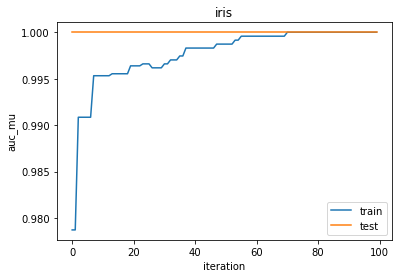

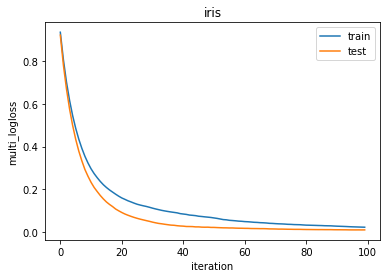

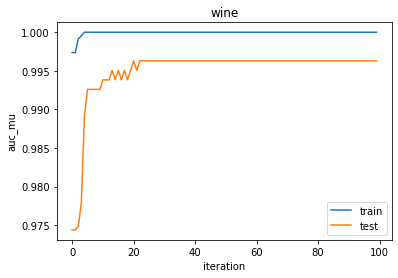

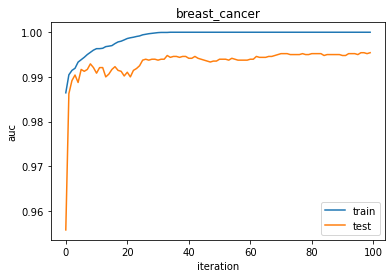

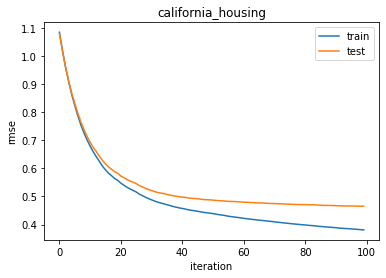

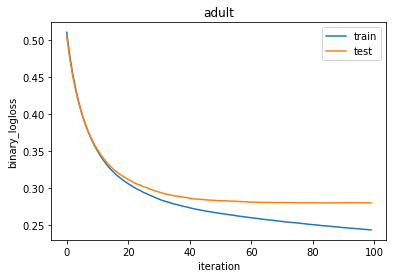

In [7]:
for model, dataset in zip(models_no_hpo, preprocessed_datasets):
    plot_learning_curve_lgb(model, dataset['name'])

In [8]:
n_jobs = 8
models_hpo = [run_lgb_hpo(dataset_preprocessed, n_jobs=n_jobs) for dataset_preprocessed in preprocessed_datasets]

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6387926357773329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6387926357773329
[LightGBM] [Warning] lambda_l2 is set=3.8092205770480323e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8092205770480323e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7085432912849436e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.7085432912849436e-10
[LightGBM] [Warning] min_gain_to_split is set=0.0012042752972516802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012042752972516802
[LightGBM] [Warning] lambda_l1 is set=3.630322466779859e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.630322466779859e-09
[LightGBM] [Warning] bagging_fraction is set=0.3807947176588889, subsample=1.0 will be ignored. Current value: bagging_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.43090431574633226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43090431574633226
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8600804638103362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8600804638103362
[LightGBM] [Warning] lambda_l2 is set=7.370749584606316e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.370749584606316e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5021299371479996e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.5021299371479996e-10
[LightGBM] [Warning] min_gain_to_split is set=4.494375874801333e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.494375874801333e-09
[LightGBM] [Warning] lambda_l1 is set=2.4941428509950143e-05, reg_alpha=0.0 will be ignored. Current value: lam

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.46196922477808117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46196922477808117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.3285238725409102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3285238725409102
[LightGBM] [Warning] lambda_l2 is set=0.0013264958610969386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013264958610969386
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.883157394589027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.883157394589027
[LightGBM] [Warning] min_gain_to_split is set=4.653826012405091e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.653826012405091e-08
[LightGBM] [Warning] lambda_l1 is set=0.0009184229517898171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.46196922477808117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46196922477808117
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.90330309864098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.90330309864098
[LightGBM] [Warning] lambda_l2 is set=0.09139301385542171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09139301385542171
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.710547126441701e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.710547126441701e-06
[LightGBM] [Warning] min_gain_to_split is set=1.90261810637728e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.90261810637728e-08
[LightGBM] [Warning] lambda_l1 is set=0.01186865625052541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011868

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.2448765966218321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2448765966218321
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.41507056692520816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41507056692520816
[LightGBM] [Warning] lambda_l2 is set=0.043820330698063355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.043820330698063355
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0019701612703884462, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0019701612703884462
[LightGBM] [Warning] min_gain_to_split is set=1.7504901217034407e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7504901217034407e-10
[LightGBM] [Warning] lambda_l1 is set=0.0004889231449234204, reg_alpha=0.0 will be ignored. Current value: lambda

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.6238860661420568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6238860661420568
[LightGBM] [Warning] bagging_fraction is set=0.02424955374345831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.02424955374345831
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1847412894417041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1847412894417041
[LightGBM] [Warning] lambda_l2 is set=5.666340897074983e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.666340897074983e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.195878664025177e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.195878664025177e-07
[LightGBM] [Warning] min_gain_to_split is set=0.011725456788106615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.11319305052090793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11319305052090793
[LightGBM] [Warning] bagging_fraction is set=0.3046588227642178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3046588227642178
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.45028151086074686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45028151086074686
[LightGBM] [Warning] lambda_l2 is set=8.182137393788155e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.182137393788155e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.733727332340865e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.733727332340865e-10
[LightGBM] [Warning] min_gain_to_split is set=8.516410323385669e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.04852787584914249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04852787584914249
[LightGBM] [Warning] bagging_fraction is set=0.748584430472769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748584430472769
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.43738352157133364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43738352157133364
[LightGBM] [Warning] lambda_l2 is set=1.7217035906359078e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7217035906359078e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=16.654244858986864, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=16.654244858986864
[LightGBM] [Warning] min_gain_to_split is set=1.8923919452820526e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.892

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=2.2052749804866655e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2052749804866655e-05
[LightGBM] [Warning] lambda_l1 is set=1.4066790626944138e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4066790626944138e-06
[LightGBM] [Warning] bagging_fraction is set=0.9702152538364571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9702152538364571
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8544958342400241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8544958342400241
[LightGBM] [Warning] lambda_l2 is set=5.420891555072896e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.420891555072896e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.02983759905781446, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=2.5626315144631354e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5626315144631354e-10
[LightGBM] [Warning] lambda_l1 is set=1.3080132506610772e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3080132506610772e-06
[LightGBM] [Warning] bagging_fraction is set=0.14743890092291603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14743890092291603
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.2620605451143687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2620605451143687
[LightGBM] [Warning] lambda_l2 is set=0.05535744644230305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05535744644230305
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.112229247361778e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=5.102500391251607e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.102500391251607e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.2165951023118492e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.2165951023118492e-10
[LightGBM] [Warning] min_gain_to_split is set=0.21722921740251852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21722921740251852
[LightGBM] [Warning] lambda_l1 is set=0.00028785409581277214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028785409581277214
[LightGBM] [Warning] bagging_fraction is set=0.5688139570974149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5688139570974149
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8657357660525316, colsample_bytree=1.0 will be ignored. Current value: feature_frac

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.03215693147382613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03215693147382613
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15.795149361964512, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=15.795149361964512
[LightGBM] [Warning] min_gain_to_split is set=0.21349154050409336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21349154050409336
[LightGBM] [Warning] lambda_l1 is set=1.1667894701943316e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1667894701943316e-09
[LightGBM] [Warning] bagging_fraction is set=0.1255291035002645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1255291035002645
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6454916929502548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64549

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6276068488151175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6276068488151175
[LightGBM] [Warning] lambda_l2 is set=1.5174061440419037e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5174061440419037e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.6619088348858315, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.6619088348858315
[LightGBM] [Warning] min_gain_to_split is set=0.0009257809474506973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009257809474506973
[LightGBM] [Warning] lambda_l1 is set=0.00013017942662065294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013017942662065294
[LightGBM] [Warning] bagging_fraction is set=0.9478105062156972, subsample=1.0 will be ignored. Current value: bagging_frac

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.4147346063656e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.4147346063656e-10
[LightGBM] [Warning] min_gain_to_split is set=4.519945250377302e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.519945250377302e-09
[LightGBM] [Warning] lambda_l1 is set=4.539428951761876e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.539428951761876e-06
[LightGBM] [Warning] bagging_fraction is set=0.4041870066550339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4041870066550339
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8771663265516613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8771663265516613
[LightGBM] [Warning] lambda_l2 is set=6.432351680688273e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.313067878697781, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.313067878697781
[LightGBM] [Warning] min_gain_to_split is set=1.5671308165910713e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5671308165910713e-08
[LightGBM] [Warning] lambda_l1 is set=0.0001743769505116775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001743769505116775
[LightGBM] [Warning] bagging_fraction is set=0.8268562581084332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8268562581084332
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.631265448263327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.631265448263327
[LightGBM] [Warning] lambda_l2 is set=1.2419854896108026e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.9711946598538108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9711946598538108
[LightGBM] [Warning] lambda_l2 is set=0.0023039435656809133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023039435656809133
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00037033143236237756, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00037033143236237756
[LightGBM] [Warning] min_gain_to_split is set=7.696717249710945e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.696717249710945e-08
[LightGBM] [Warning] lambda_l1 is set=9.887107892214888e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.887107892214888e-09
[LightGBM] [Warning] bagging_fraction is set=0.7717980038600175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7717980038600175
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Curr

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=1.4217400988869775e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4217400988869775e-09
[LightGBM] [Warning] bagging_fraction is set=0.043606518799940854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.043606518799940854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7579213043124534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7579213043124534
[LightGBM] [Warning] lambda_l2 is set=1.6505420659757325e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6505420659757325e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.01768177532467e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.01768177532467e-05
[LightGBM] [Warning] min_gain_to_split is set=3.559892227993325e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_t

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=2.6242757892182085e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6242757892182085e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.006659447828438181, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.006659447828438181
[LightGBM] [Warning] min_gain_to_split is set=0.0003871093553311964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0003871093553311964
[LightGBM] [Warning] lambda_l1 is set=7.101159841526466e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.101159841526466e-09
[LightGBM] [Warning] bagging_fraction is set=0.9624777979064765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9624777979064765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9552136184387222, colsample_bytree=1.0 will be ignored. Current value: feature_frac

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.009547578139751434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009547578139751434
[LightGBM] [Warning] bagging_fraction is set=0.39048338068808486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39048338068808486
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.21199380156717074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21199380156717074
[LightGBM] [Warning] lambda_l2 is set=3.8888976742207376e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8888976742207376e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.6330957960832593, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.6330957960832593
[LightGBM] [Warning] min_gain_to_split is set=0.00010185549516645089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_ite

[LightGBM] [Warning] lambda_l1 is set=0.05843240728238473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05843240728238473
[LightGBM] [Warning] bagging_fraction is set=0.6650386233297361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650386233297361
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5681512988908587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681512988908587
[LightGBM] [Warning] lambda_l2 is set=1.496445278309383e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.496445278309383e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.096681765848783, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.096681765848783
[LightGBM] [Warning] min_gain_to_split is set=1.9470241586431447e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9470241

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.6387926357773329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6387926357773329
[LightGBM] [Warning] lambda_l2 is set=3.8092205770480323e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8092205770480323e-10
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.8341182143924175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8341182143924175
[LightGBM] [Warning] lambda_l1 is set=0.00014955987595458335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014955987595458335
[LightGBM] [Warning] min_gain_to_split is set=1.7690764556597108e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7690764556597108e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.3024848611373622e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.5920392514089517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5920392514089517
[LightGBM] [Warning] lambda_l2 is set=0.0056406380619278725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0056406380619278725
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5256259174255654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5256259174255654
[LightGBM] [Warning] lambda_l1 is set=2.4941428509950143e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4941428509950143e-05
[LightGBM] [Warning] min_gain_to_split is set=4.494375874801333e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.494375874801333e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5021299371479996e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=8.531544847468896e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.531544847468896e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.3786759293943487, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.3786759293943487
[LightGBM] [Warning] feature_fraction is set=0.33214746494364006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33214746494364006
[LightGBM] [Warning] lambda_l2 is set=3.564577947646552e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.564577947646552e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.21698090453033655, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21698090453033655
[LightGBM] [Warning] lambda_l1 is set=0.014866954148482726, reg_alpha=0.0 will be ignored. Current value: lambda_l1

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=0.0003308358733271454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0003308358733271454
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.423530436937091e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.423530436937091e-08
[LightGBM] [Warning] feature_fraction is set=0.43505448990556883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43505448990556883
[LightGBM] [Warning] lambda_l2 is set=6.905732433818269e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.905732433818269e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6103647690629941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6103647690629941
[LightGBM] [Warning] lambda_l1 is set=0.5453036034150963, reg_alpha=0.0 will be ignored. Current value: lambda_l1

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.04018335397791034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04018335397791034
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.045582851058774666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.045582851058774666
[LightGBM] [Warning] lambda_l1 is set=0.024509532115519716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024509532115519716
[LightGBM] [Warning] min_gain_to_split is set=1.0780903203357862e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0780903203357862e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00011737743636969904, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00011737743636969904
[LightGBM] [Warning] feature_fraction is set=0.2395374550549698, colsample_bytree=1.0 will be ignored. Current value: feature_fr

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=1.2987903422386251e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2987903422386251e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.05065684160019703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.05065684160019703
[LightGBM] [Warning] lambda_l1 is set=6.089250120938895e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.089250120938895e-10
[LightGBM] [Warning] min_gain_to_split is set=0.0007673597359720702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007673597359720702
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.5461898540304743e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.5461898540304743e-10
[LightGBM] [Warning] feature_fraction is set=0.3437490261358668, colsample_bytree=1.0 will be ignored. Current value: featur

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=2.2106421422935183e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2106421422935183e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7793754467681624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793754467681624
[LightGBM] [Warning] lambda_l1 is set=2.006897953936309e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.006897953936309e-07
[LightGBM] [Warning] min_gain_to_split is set=1.5423365931260987e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5423365931260987e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.128960678157801e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.128960678157801e-09
[LightGBM] [Warning] feature_fraction is set=0.7345759278669939, colsample_bytree=1.0 will be ignored. Current value: feature_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.013427515815396423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013427515815396423
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5181929070054689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5181929070054689
[LightGBM] [Warning] lambda_l1 is set=5.086528364852211e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.086528364852211e-07
[LightGBM] [Warning] min_gain_to_split is set=0.003418077083570108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003418077083570108
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.786984815660297e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.786984815660297e-06
[LightGBM] [Warning] feature_fraction is set=0.9879756206510579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.4550696187473169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4550696187473169
[LightGBM] [Warning] lambda_l2 is set=4.975068204241548e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.975068204241548e-09
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.4587084383605427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4587084383605427
[LightGBM] [Warning] lambda_l1 is set=0.00010661512495104578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010661512495104578
[LightGBM] [Warning] min_gain_to_split is set=0.31477420295423625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31477420295423625
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.015899297390426777, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.1255291035002645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1255291035002645
[LightGBM] [Warning] lambda_l1 is set=1.1667894701943316e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1667894701943316e-09
[LightGBM] [Warning] min_gain_to_split is set=0.21349154050409336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21349154050409336
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15.795149361964512, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=15.795149361964512
[LightGBM] [Warning] feature_fraction is set=0.6454916929502548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6454916929502548
[LightGBM] [Warning] lambda_l2 is set=0.03215693147382613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032156

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.4225349731022325e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.4225349731022325e-09
[LightGBM] [Warning] feature_fraction is set=0.16202938543049691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16202938543049691
[LightGBM] [Warning] lambda_l2 is set=0.025374431435722104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025374431435722104
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5291463666343043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5291463666343043
[LightGBM] [Warning] lambda_l1 is set=3.567816086528645e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.567816086528645e-09
[LightGBM] [Warning] min_gain_to_split is set=5.40870335447311e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_s

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0011493329674790388, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0011493329674790388
[LightGBM] [Warning] feature_fraction is set=0.6699166974198645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6699166974198645
[LightGBM] [Warning] lambda_l2 is set=1.6895416278482486e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6895416278482486e-09
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8973724603359086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8973724603359086
[LightGBM] [Warning] lambda_l1 is set=0.030288722386182333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030288722386182333
[LightGBM] [Warning] min_gain_to_split is set=0.12771444940171506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=5.882094754865963e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.882094754865963e-10
[LightGBM] [Warning] min_gain_to_split is set=5.300021048178211e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.300021048178211e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.12183384767753914, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.12183384767753914
[LightGBM] [Warning] feature_fraction is set=0.30700795355893273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30700795355893273
[LightGBM] [Warning] lambda_l2 is set=0.000918095288722197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000918095288722197
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6650386233297361, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=6.879381898544646e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.879381898544646e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1227286893603354e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1227286893603354e-07
[LightGBM] [Warning] feature_fraction is set=0.7471413146658209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7471413146658209
[LightGBM] [Warning] lambda_l2 is set=5.761081538592328e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.761081538592328e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6650386233297361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650386233297361
[LightGBM] [Warning] lambda_l1 is set=0.05843240728238473, reg_alpha=0.0 will be ignored. Current value: lambda_l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=0.0003871093553311964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0003871093553311964
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.006659447828438181, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.006659447828438181
[LightGBM] [Warning] feature_fraction is set=0.9552136184387222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552136184387222
[LightGBM] [Warning] lambda_l2 is set=2.6242757892182085e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6242757892182085e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9624777979064765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9624777979064765
[LightGBM] [Warning] lambda_l1 is set=7.101159841526466e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=0.00010185549516645089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010185549516645089
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.6330957960832593, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.6330957960832593
[LightGBM] [Warning] feature_fraction is set=0.21199380156717074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21199380156717074
[LightGBM] [Warning] lambda_l2 is set=3.8888976742207376e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8888976742207376e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.39048338068808486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39048338068808486
[LightGBM] [Warning] lambda_l1 is set=0.009547578139751434, reg_alpha=0.0 will be ignored. Current value: lambda_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=5.77176439684951e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.77176439684951e-10
[LightGBM] [Warning] min_gain_to_split is set=3.0067137178443515e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0067137178443515e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.004594950927329506, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.004594950927329506
[LightGBM] [Warning] feature_fraction is set=0.29816488175483025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29816488175483025
[LightGBM] [Warning] lambda_l2 is set=0.0325139056006553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0325139056006553
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5372764942067545, subsample=1.0 will be ignored. Current value: bagging_fraction=0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.8898605990702875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8898605990702875
[LightGBM] [Warning] lambda_l1 is set=1.9521521064042855e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9521521064042855e-07
[LightGBM] [Warning] min_gain_to_split is set=1.1241425798814278e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1241425798814278e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0072826274189412, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0072826274189412
[LightGBM] [Warning] feature_fraction is set=0.866974180012307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.866974180012307
[LightGBM] [Warning] lambda_l2 is set=0.2069640351584232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2069640351584232
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: b

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.0056406380619278725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0056406380619278725
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.900574807217312e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.900574807217312e-07
[LightGBM] [Warning] min_gain_to_split is set=0.0018737858652621534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018737858652621534
[LightGBM] [Warning] lambda_l1 is set=0.4964165793318546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4964165793318546
[LightGBM] [Warning] bagging_fraction is set=0.43090431574633226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43090431574633226
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.10496990541124217, colsample_bytree=1.0 will be ignored. Current value: feature_fractio

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.6709162102312274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6709162102312274
[LightGBM] [Warning] lambda_l2 is set=3.004911222894518e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.004911222894518e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5047906912809951e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.5047906912809951e-06
[LightGBM] [Warning] min_gain_to_split is set=6.434773480911294e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.434773480911294e-10
[LightGBM] [Warning] lambda_l1 is set=2.038664841329954e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.038664841329954e-05
[LightGBM] [Warning] bagging_fraction is set=0.042720225571542904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.042720225571542904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. 

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.33214746494364006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33214746494364006
[LightGBM] [Warning] lambda_l2 is set=3.564577947646552e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.564577947646552e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.3786759293943487, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.3786759293943487
[LightGBM] [Warning] min_gain_to_split is set=8.531544847468896e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.531544847468896e-10
[LightGBM] [Warning] lambda_l1 is set=0.014866954148482726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014866954148482726
[LightGBM] [Warning] bagging_fraction is set=0.21698090453033655, subsample=1.0 will be ignored. Current value: bagging_fractio

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.895144620039633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895144620039633
[LightGBM] [Warning] lambda_l2 is set=2.0300327610941567e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0300327610941567e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.848991703563798e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.848991703563798e-07
[LightGBM] [Warning] min_gain_to_split is set=5.668427026755635e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.668427026755635e-10
[LightGBM] [Warning] lambda_l1 is set=0.3394051831317331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3394051831317331
[LightGBM] [Warning] bagging_fraction is set=0.9410539985093852, subsample=1.0 will be ignored. Current value: bagging_fraction=0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.1847412894417041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1847412894417041
[LightGBM] [Warning] lambda_l2 is set=5.666340897074983e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.666340897074983e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.195878664025177e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.195878664025177e-07
[LightGBM] [Warning] min_gain_to_split is set=0.011725456788106615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011725456788106615
[LightGBM] [Warning] lambda_l1 is set=0.6238860661420568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6238860661420568
[LightGBM] [Warning] bagging_fraction is set=0.02424955374345831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.02424955374345831
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current valu

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.45028151086074686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45028151086074686
[LightGBM] [Warning] lambda_l2 is set=8.182137393788155e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.182137393788155e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.733727332340865e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.733727332340865e-10
[LightGBM] [Warning] min_gain_to_split is set=8.516410323385669e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.516410323385669e-06
[LightGBM] [Warning] lambda_l1 is set=0.11319305052090793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11319305052090793
[LightGBM] [Warning] bagging_fraction is set=0.3046588227642178, subsample=1.0 will be ignored. Current value: bagging_fracti

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=0.0020724189414873554, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020724189414873554
[LightGBM] [Warning] lambda_l1 is set=6.61219610933699e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.61219610933699e-08
[LightGBM] [Warning] bagging_fraction is set=0.3548532384086654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3548532384086654
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7615639394234972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7615639394234972
[LightGBM] [Warning] lambda_l2 is set=5.948335253934374e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.948335253934374e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.7734827069796097e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=3.1927793878238464e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1927793878238464e-09
[LightGBM] [Warning] lambda_l1 is set=4.449821718394306e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.449821718394306e-09
[LightGBM] [Warning] bagging_fraction is set=0.42406060592771266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42406060592771266
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8889953373332135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8889953373332135
[LightGBM] [Warning] lambda_l2 is set=1.2958393561947964e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2958393561947964e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0005179514289260394, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=5.782384515418277e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.782384515418277e-06
[LightGBM] [Warning] bagging_fraction is set=0.6219469580533169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6219469580533169
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.11996626782727147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11996626782727147
[LightGBM] [Warning] lambda_l2 is set=0.020592776245916794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020592776245916794
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.8073998408131337, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.8073998408131337
[LightGBM] [Warning] min_gain_to_split is set=4.067988489042578e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.06

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=1.6626148525058868e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6626148525058868e-07
[LightGBM] [Warning] lambda_l1 is set=2.6589185649897408e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6589185649897408e-08
[LightGBM] [Warning] bagging_fraction is set=0.040167431206258215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.040167431206258215
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5026711301411092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5026711301411092
[LightGBM] [Warning] lambda_l2 is set=4.925295701561622e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.925295701561622e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.452337671523552e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14664118314018423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14664118314018423
[LightGBM] [Warning] lambda_l2 is set=4.302785582286315e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.302785582286315e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.7056374670562223e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.7056374670562223e-09
[LightGBM] [Warning] min_gain_to_split is set=7.562773825022096e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.562773825022096e-10
[LightGBM] [Warning] lambda_l1 is set=2.208751052131933e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.208751052131933e-09
[LightGBM] [Warning] bagging_fraction is set=0.48632870083626933, subsample=1.0 will be ignored. Current value: bagging

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=1.1667894701943316e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1667894701943316e-09
[LightGBM] [Warning] bagging_fraction is set=0.1255291035002645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1255291035002645
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6454916929502548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6454916929502548
[LightGBM] [Warning] lambda_l2 is set=0.03215693147382613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03215693147382613
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15.795149361964512, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=15.795149361964512
[LightGBM] [Warning] min_gain_to_split is set=0.21349154050409336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.213491

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=6.140668537606107e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.140668537606107e-07
[LightGBM] [Warning] bagging_fraction is set=0.877997980394132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.877997980394132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.19262442766973054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19262442766973054
[LightGBM] [Warning] lambda_l2 is set=3.7153710503798395e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7153710503798395e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.184222043621915e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.184222043621915e-06
[LightGBM] [Warning] min_gain_to_split is set=7.304236389189969e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_sp

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=1.5174061440419037e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5174061440419037e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.6619088348858315, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.6619088348858315
[LightGBM] [Warning] min_gain_to_split is set=0.0009257809474506973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009257809474506973
[LightGBM] [Warning] lambda_l1 is set=0.00013017942662065294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013017942662065294
[LightGBM] [Warning] bagging_fraction is set=0.9478105062156972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9478105062156972
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6276068488151175, colsample_bytree=1.0 will be ignored. Current value: feature_frac

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

lit=0.0009737748004905858
[LightGBM] [Warning] lambda_l1 is set=6.623253661034365e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.623253661034365e-09
[LightGBM] [Warning] bagging_fraction is set=0.12309554666119286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12309554666119286
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9868305810175612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9868305810175612
[LightGBM] [Warning] lambda_l2 is set=7.043421383493666e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.043421383493666e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.541849615866756e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.541849615866756e-06
[LightGBM] [Warning] min_gain_to_split is set=0.0009737748004905858, min_split_gain=0.0 will be ignored. Cur

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=5.8232408793203695e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.8232408793203695e-05
[LightGBM] [Warning] lambda_l1 is set=0.0008169934525884355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008169934525884355
[LightGBM] [Warning] bagging_fraction is set=0.6486036260916361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6486036260916361
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.21904859001279736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21904859001279736
[LightGBM] [Warning] lambda_l2 is set=0.0006789512065865471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006789512065865471
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.2505649991109054e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_i

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.01768177532467e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.01768177532467e-05
[LightGBM] [Warning] min_gain_to_split is set=3.559892227993325e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.559892227993325e-06
[LightGBM] [Warning] lambda_l1 is set=1.4217400988869775e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4217400988869775e-09
[LightGBM] [Warning] bagging_fraction is set=0.043606518799940854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.043606518799940854
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.30700795355893273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30700795355893273
[LightGBM] [Warning] lambda_l2 is set=0.000918095288722197, reg_lambda=0.0 will be ignored. Current value: lam

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.7471413146658209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7471413146658209
[LightGBM] [Warning] lambda_l2 is set=5.761081538592328e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.761081538592328e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1227286893603354e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1227286893603354e-07
[LightGBM] [Warning] min_gain_to_split is set=6.879381898544646e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.879381898544646e-06
[LightGBM] [Warning] lambda_l1 is set=4.6136686749326114e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6136686749326114e-05
[LightGBM] [Warning] bagging_fraction is set=0.8387082007959991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387082007959991
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Cu

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.14741545237950573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14741545237950573
[LightGBM] [Warning] lambda_l2 is set=6.277883737356713e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277883737356713e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.328965107901461e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.328965107901461e-07
[LightGBM] [Warning] min_gain_to_split is set=8.260253033426615e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.260253033426615e-10
[LightGBM] [Warning] lambda_l1 is set=2.3766636947325307e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3766636947325307e-10
[LightGBM] [Warning] bagging_fraction is set=0.9979547694280041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9979547694280041
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Cu

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.1025676676836366e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.1025676676836366e-08
[LightGBM] [Warning] min_gain_to_split is set=5.8247906385181635e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.8247906385181635e-09
[LightGBM] [Warning] lambda_l1 is set=0.000313665309728837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000313665309728837
[LightGBM] [Warning] bagging_fraction is set=0.7459192946646879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7459192946646879
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3085045312450991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3085045312450991
[LightGBM] [Warning] lambda_l2 is set=0.00011950001197063381, reg_lambda=0.0 will be ignored. Current value: lambd

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.00011950001197063381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011950001197063381
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.1025676676836366e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.1025676676836366e-08
[LightGBM] [Warning] min_gain_to_split is set=5.8247906385181635e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.8247906385181635e-09
[LightGBM] [Warning] lambda_l1 is set=0.000313665309728837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000313665309728837
[LightGBM] [Warning] bagging_fraction is set=0.7459192946646879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7459192946646879
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3085045312450991, colsample_bytree=1.0 will be ignored. Current value: feature_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.37269822486075477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37269822486075477
[LightGBM] [Warning] lambda_l1 is set=4.651884598909631e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.651884598909631e-06
[LightGBM] [Warning] min_gain_to_split is set=1.3572180024688837e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3572180024688837e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.4447803385311335, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.4447803385311335
[LightGBM] [Warning] feature_fraction is set=0.4442157921404465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4442157921404465
[LightGBM] [Warning] lambda_l2 is set=0.03975612682497516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03975612682497516
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current valu

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.6270651455592824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6270651455592824
[LightGBM] [Warning] lambda_l1 is set=0.000487991802546047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000487991802546047
[LightGBM] [Warning] min_gain_to_split is set=5.274110827759772e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.274110827759772e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.2466641775692944e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.2466641775692944e-09
[LightGBM] [Warning] feature_fraction is set=0.1858691048413702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1858691048413702
[LightGBM] [Warning] lambda_l2 is set=0.0004562717351344852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004562717351344852
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Curren

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.042720225571542904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.042720225571542904
[LightGBM] [Warning] lambda_l1 is set=2.038664841329954e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.038664841329954e-05
[LightGBM] [Warning] min_gain_to_split is set=6.434773480911294e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.434773480911294e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5047906912809951e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.5047906912809951e-06
[LightGBM] [Warning] feature_fraction is set=0.6709162102312274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6709162102312274
[LightGBM] [Warning] lambda_l2 is set=3.004911222894518e-06, reg_lambda=0.0 will be ignored. Current value: la

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.86212327742378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86212327742378
[LightGBM] [Warning] lambda_l1 is set=7.051795568074419e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.051795568074419e-06
[LightGBM] [Warning] min_gain_to_split is set=4.818484005569784e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.818484005569784e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.9666137640849908e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.9666137640849908e-08
[LightGBM] [Warning] feature_fraction is set=0.24819026782864756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24819026782864756
[LightGBM] [Warning] lambda_l2 is set=0.0008401567653776076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008401567653776076
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Curren

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.0012277500743431305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012277500743431305
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5231463558400994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5231463558400994
[LightGBM] [Warning] lambda_l1 is set=2.323877945912794e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.323877945912794e-09
[LightGBM] [Warning] min_gain_to_split is set=3.6481226924071494e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6481226924071494e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0008142069201789205, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0008142069201789205
[LightGBM] [Warning] feature_fraction is set=0.39029568781474044, colsample_bytree=1.0 will be ignored. Current value: feature_f

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.2757901083212553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2757901083212553
[LightGBM] [Warning] lambda_l1 is set=0.22990464275110875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22990464275110875
[LightGBM] [Warning] min_gain_to_split is set=0.00014127726116954965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00014127726116954965
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15.439323154433273, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=15.439323154433273
[LightGBM] [Warning] feature_fraction is set=0.2525434720174833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2525434720174833
[LightGBM] [Warning] lambda_l2 is set=0.0009126367790369129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009126367790369129
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value:

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.6179267600882911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6179267600882911
[LightGBM] [Warning] lambda_l2 is set=3.824097044816814e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.824097044816814e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9448090811539157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448090811539157
[LightGBM] [Warning] lambda_l1 is set=0.0002709456509764319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002709456509764319
[LightGBM] [Warning] min_gain_to_split is set=7.261500607130863e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.261500607130863e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.285232113778884, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.9448090811539157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448090811539157
[LightGBM] [Warning] lambda_l1 is set=0.0002709456509764319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002709456509764319
[LightGBM] [Warning] min_gain_to_split is set=7.261500607130863e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.261500607130863e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.285232113778884, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.285232113778884
[LightGBM] [Warning] feature_fraction is set=0.6179267600882911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6179267600882911
[LightGBM] [Warning] lambda_l2 is set=3.824097044816814e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.824097044816814e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value:

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.04852787584914249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04852787584914249
[LightGBM] [Warning] min_gain_to_split is set=1.8923919452820526e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8923919452820526e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=16.654244858986864, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=16.654244858986864
[LightGBM] [Warning] feature_fraction is set=0.43738352157133364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43738352157133364
[LightGBM] [Warning] lambda_l2 is set=1.7217035906359078e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7217035906359078e-08
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.748584430472769, subsample=1.0 will be ignored. Current value: bagging_fraction=

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.9879756206510579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9879756206510579
[LightGBM] [Warning] lambda_l2 is set=0.013427515815396423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013427515815396423
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5181929070054689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5181929070054689
[LightGBM] [Warning] lambda_l1 is set=5.086528364852211e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.086528364852211e-07
[LightGBM] [Warning] min_gain_to_split is set=0.003418077083570108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003418077083570108
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.786984815660297e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.5181929070054689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5181929070054689
[LightGBM] [Warning] lambda_l1 is set=5.086528364852211e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.086528364852211e-07
[LightGBM] [Warning] min_gain_to_split is set=0.003418077083570108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003418077083570108
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.786984815660297e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.786984815660297e-06
[LightGBM] [Warning] feature_fraction is set=0.9879756206510579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9879756206510579
[LightGBM] [Warning] lambda_l2 is set=0.013427515815396423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013427515815396423
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current va

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.783959868043827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.783959868043827
[LightGBM] [Warning] lambda_l2 is set=4.2015895583096116e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2015895583096116e-10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.4896777553391111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4896777553391111
[LightGBM] [Warning] lambda_l1 is set=0.0016038384241059528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016038384241059528
[LightGBM] [Warning] min_gain_to_split is set=0.0007441406923959134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007441406923959134
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.34918000832299867, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_lea

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002882784309486424, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0002882784309486424
[LightGBM] [Warning] feature_fraction is set=0.9725233899478319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9725233899478319
[LightGBM] [Warning] lambda_l2 is set=3.793396773300525e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.793396773300525e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8976441603442806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8976441603442806
[LightGBM] [Warning] lambda_l1 is set=0.014815649988486607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014815649988486607
[LightGBM] [Warning] min_gain_to_split is set=3.695123261679187e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.0023039435656809133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023039435656809133
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7717980038600175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7717980038600175
[LightGBM] [Warning] lambda_l1 is set=9.887107892214888e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.887107892214888e-09
[LightGBM] [Warning] min_gain_to_split is set=7.696717249710945e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.696717249710945e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00037033143236237756, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00037033143236237756
[LightGBM] [Warning] feature_fraction is set=0.9711946598538108, colsample_bytree=1.0 will be ignored. Current value: feature_fr

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.877997980394132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.877997980394132
[LightGBM] [Warning] lambda_l1 is set=6.140668537606107e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.140668537606107e-07
[LightGBM] [Warning] min_gain_to_split is set=7.304236389189969e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.304236389189969e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.184222043621915e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.184222043621915e-06
[LightGBM] [Warning] feature_fraction is set=0.19262442766973054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19262442766973054
[LightGBM] [Warning] lambda_l2 is set=3.7153710503798395e-06, reg_lambda=0.0 will be ignored. Current value: lambda_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=8.180019848086051e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.180019848086051e-05
[LightGBM] [Warning] min_gain_to_split is set=0.010679095885662494, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010679095885662494
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1280974847752914e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1280974847752914e-10
[LightGBM] [Warning] feature_fraction is set=0.8829067258559155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8829067258559155
[LightGBM] [Warning] lambda_l2 is set=9.772980645745485e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.772980645745485e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8391158811124672, subsample=1.0 will be ignored. Current value: bagging_frac

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=1.4181978546476076e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4181978546476076e-05
[LightGBM] [Warning] min_gain_to_split is set=1.0518410194261021e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0518410194261021e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0005351357185895009, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0005351357185895009
[LightGBM] [Warning] feature_fraction is set=0.2980874926729874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2980874926729874
[LightGBM] [Warning] lambda_l2 is set=0.5693943544878408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5693943544878408
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7826907504706268, subsample=1.0 will be ignored. Current value: bagging_fracti

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=2.5129589054181513e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5129589054181513e-09
[LightGBM] [Warning] min_gain_to_split is set=0.00010119722517772164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010119722517772164
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.003277927979199848, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.003277927979199848
[LightGBM] [Warning] feature_fraction is set=0.7481823234690662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481823234690662
[LightGBM] [Warning] lambda_l2 is set=4.33349227131436e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.33349227131436e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.6549061844683456, subsample=1.0 will be ignored. Current value: bagging_fr

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=5.300021048178211e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.300021048178211e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.12183384767753914, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.12183384767753914
[LightGBM] [Warning] feature_fraction is set=0.30700795355893273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30700795355893273
[LightGBM] [Warning] lambda_l2 is set=0.000918095288722197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000918095288722197
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6536656769387958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6536656769387958
[LightGBM] [Warning] lambda_l1 is set=5.882094754865963e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=5.761081538592328e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.761081538592328e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8387082007959991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387082007959991
[LightGBM] [Warning] lambda_l1 is set=4.6136686749326114e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6136686749326114e-05
[LightGBM] [Warning] min_gain_to_split is set=6.879381898544646e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.879381898544646e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1227286893603354e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1227286893603354e-07
[LightGBM] [Warning] feature_fraction is set=0.7471413146658209, colsample_bytree=1.0 will be ignored. Current value: feature_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=1.4206243133229195e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4206243133229195e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.555589144689201e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.555589144689201e-05
[LightGBM] [Warning] feature_fraction is set=0.8206927184168875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8206927184168875
[LightGBM] [Warning] lambda_l2 is set=1.5226625514083211e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5226625514083211e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7817886288310858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7817886288310858
[LightGBM] [Warning] lambda_l1 is set=1.4562643917307401e-08, reg_alpha=0.0 will be ignored. Current value: lam

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8984617865657418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984617865657418
[LightGBM] [Warning] lambda_l1 is set=2.3428486242194095e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3428486242194095e-05
[LightGBM] [Warning] min_gain_to_split is set=0.059512559173614206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.059512559173614206
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.0035847379507581e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.0035847379507581e-07
[LightGBM] [Warning] feature_fraction is set=0.3019965146529946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3019965146529946
[LightGBM] [Warning] lambda_l2 is set=8.499616842297036e-05, reg_lambda=0.0 will be ignored. Current value: lambda

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=8.499616842297036e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.499616842297036e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8984617865657418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984617865657418
[LightGBM] [Warning] lambda_l1 is set=2.3428486242194095e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3428486242194095e-05
[LightGBM] [Warning] min_gain_to_split is set=0.059512559173614206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.059512559173614206
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.0035847379507581e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.0035847379507581e-07
[LightGBM] [Warning] feature_fraction is set=0.3019965146529946, colsample_bytree=1.0 will be ignored. Current value: feature_fr

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.00011950001197063381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011950001197063381
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8898605990702875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8898605990702875
[LightGBM] [Warning] lambda_l1 is set=1.9521521064042855e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9521521064042855e-07
[LightGBM] [Warning] min_gain_to_split is set=1.1241425798814278e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1241425798814278e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0072826274189412, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0072826274189412
[LightGBM] [Warning] feature_fraction is set=0.866974180012307, colsample_bytree=1.0 will be ignored. Current value: feature_fract

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.37269822486075477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37269822486075477
[LightGBM] [Warning] lambda_l1 is set=4.651884598909631e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.651884598909631e-06
[LightGBM] [Warning] min_gain_to_split is set=1.3572180024688837e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3572180024688837e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.4447803385311335, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.4447803385311335
[LightGBM] [Warning] feature_fraction is set=0.4442157921404465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4442157921404465
[LightGBM] [Warning] lambda_l2 is set=0.03975612682497516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.8600804638103362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8600804638103362
[LightGBM] [Warning] lambda_l2 is set=7.370749584606316e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.370749584606316e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5256259174255654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5256259174255654
[LightGBM] [Warning] lambda_l1 is set=2.4941428509950143e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4941428509950143e-05
[LightGBM] [Warning] min_gain_to_split is set=4.494375874801333e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.494375874801333e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5021299371479996e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.1879049026057455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1879049026057455
[LightGBM] [Warning] lambda_l2 is set=1.661048634233464e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.661048634233464e-09
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.43090431574633226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43090431574633226
[LightGBM] [Warning] lambda_l1 is set=0.4964165793318546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4964165793318546
[LightGBM] [Warning] min_gain_to_split is set=0.0018737858652621534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018737858652621534
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.900574807217312e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.19262898755063e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.19262898755063e-07
[LightGBM] [Warning] feature_fraction is set=0.4693446307320668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4693446307320668
[LightGBM] [Warning] lambda_l2 is set=5.885713232276749e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.885713232276749e-10
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.14793813986181695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14793813986181695
[LightGBM] [Warning] lambda_l1 is set=1.9408038941379924e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9408038941379924e-08
[LightGBM] [Warning] min_gain_to_split is set=0.0001752025735939189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_sp

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6270651455592824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6270651455592824
[LightGBM] [Warning] lambda_l1 is set=0.000487991802546047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000487991802546047
[LightGBM] [Warning] min_gain_to_split is set=5.274110827759772e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.274110827759772e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.2466641775692944e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.2466641775692944e-09
[LightGBM] [Warning] feature_fraction is set=0.1858691048413702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1858691048413702
[LightGBM] [Warning] lambda_l2 is set=0.0004562717351344852, reg_lambda=0.0 will be ignored. Current value: lambda_l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.9666137640849908e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.9666137640849908e-08
[LightGBM] [Warning] feature_fraction is set=0.24819026782864756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24819026782864756
[LightGBM] [Warning] lambda_l2 is set=0.0008401567653776076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008401567653776076
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.86212327742378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86212327742378
[LightGBM] [Warning] lambda_l1 is set=7.051795568074419e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.051795568074419e-06
[LightGBM] [Warning] min_gain_to_split is set=4.818484005569784e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_spli

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=1.9408038941379924e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9408038941379924e-08
[LightGBM] [Warning] min_gain_to_split is set=0.0001752025735939189, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0001752025735939189
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.19262898755063e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.19262898755063e-07
[LightGBM] [Warning] feature_fraction is set=0.4693446307320668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4693446307320668
[LightGBM] [Warning] lambda_l2 is set=5.885713232276749e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.885713232276749e-10
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.46196922477808117, subsample=1.0 will be ignored. Current value: bagging_fra

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.4097978093474604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4097978093474604
[LightGBM] [Warning] lambda_l1 is set=0.0009184229517898171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009184229517898171
[LightGBM] [Warning] min_gain_to_split is set=4.653826012405091e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.653826012405091e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.883157394589027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.883157394589027
[LightGBM] [Warning] feature_fraction is set=0.3285238725409102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3285238725409102
[LightGBM] [Warning] lambda_l2 is set=0.0013264958610969386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013264958610969386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current valu

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.02928272051070921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02928272051070921
[LightGBM] [Warning] min_gain_to_split is set=6.940642095653195e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.940642095653195e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.707658537493673e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.707658537493673e-09
[LightGBM] [Warning] feature_fraction is set=0.3509842173329637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3509842173329637
[LightGBM] [Warning] lambda_l2 is set=0.03657993410304538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03657993410304538
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6103647690629941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6367704427005353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6367704427005353
[LightGBM] [Warning] lambda_l1 is set=0.02928272051070921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02928272051070921
[LightGBM] [Warning] min_gain_to_split is set=6.940642095653195e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.940642095653195e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.707658537493673e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.707658537493673e-09
[LightGBM] [Warning] feature_fraction is set=0.3509842173329637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3509842173329637
[LightGBM] [Warning] lambda_l2 is set=0.03657993410304538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.2448765966218321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2448765966218321
[LightGBM] [Warning] lambda_l1 is set=0.002765064271578237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002765064271578237
[LightGBM] [Warning] min_gain_to_split is set=7.919695347616761e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.919695347616761e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11.547754805864942, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11.547754805864942
[LightGBM] [Warning] feature_fraction is set=0.26094043829919594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26094043829919594
[LightGBM] [Warning] lambda_l2 is set=0.0016195682061678214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016195682061678214
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current valu

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.3394051831317331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3394051831317331
[LightGBM] [Warning] min_gain_to_split is set=5.668427026755635e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.668427026755635e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.848991703563798e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.848991703563798e-07
[LightGBM] [Warning] feature_fraction is set=0.895144620039633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895144620039633
[LightGBM] [Warning] lambda_l2 is set=2.0300327610941567e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0300327610941567e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2757901083212553, subsample=1.0 will be ignored. Current value: bagging_fraction=0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=2.557121805028822e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.557121805028822e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00047610076050079745, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00047610076050079745
[LightGBM] [Warning] feature_fraction is set=0.6690752475342215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6690752475342215
[LightGBM] [Warning] lambda_l2 is set=7.996458736748037e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.996458736748037e-10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6367704427005353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6367704427005353
[LightGBM] [Warning] lambda_l1 is set=0.02928272051070921, reg_alpha=0.0 will be ignored. Current value: lambda_l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=6.089250120938895e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.089250120938895e-10
[LightGBM] [Warning] min_gain_to_split is set=0.0007673597359720702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007673597359720702
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.5461898540304743e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.5461898540304743e-10
[LightGBM] [Warning] feature_fraction is set=0.3437490261358668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3437490261358668
[LightGBM] [Warning] lambda_l2 is set=1.7926992391224182e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7926992391224182e-10
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.05065684160019703, subsample=1.0 will be ignored. Current value: bagging

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=0.011725456788106615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011725456788106615
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.195878664025177e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.195878664025177e-07
[LightGBM] [Warning] feature_fraction is set=0.1847412894417041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1847412894417041
[LightGBM] [Warning] lambda_l2 is set=5.666340897074983e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.666340897074983e-09
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4045196870533997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4045196870533997
[LightGBM] [Warning] lambda_l1 is set=4.063836562918676e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l2 is set=0.35371445373532123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35371445373532123
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4479287074337934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4479287074337934
[LightGBM] [Warning] lambda_l1 is set=6.29997708019449e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.29997708019449e-08
[LightGBM] [Warning] min_gain_to_split is set=3.0013033640166014e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0013033640166014e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.0540420065306512e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.0540420065306512e-06
[LightGBM] [Warning] feature_fraction is set=0.7431363304300561, colsample_bytree=1.0 will be ignored. Current value: feature_fracti

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.045582851058774666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.045582851058774666
[LightGBM] [Warning] lambda_l1 is set=0.024509532115519716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024509532115519716
[LightGBM] [Warning] min_gain_to_split is set=1.0780903203357862e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0780903203357862e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00011737743636969904, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00011737743636969904
[LightGBM] [Warning] feature_fraction is set=0.2395374550549698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2395374550549698
[LightGBM] [Warning] lambda_l2 is set=0.04018335397791034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04018335397791034
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Curr

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=2.3202893619724443e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3202893619724443e-07
[LightGBM] [Warning] min_gain_to_split is set=4.045249215727987e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.045249215727987e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.033983801276371e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.033983801276371e-05
[LightGBM] [Warning] feature_fraction is set=0.13506681907921028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13506681907921028
[LightGBM] [Warning] lambda_l2 is set=0.0003607666251985232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003607666251985232
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.20383322344140348, subsample=1.0 will be ignored. Current value: bagging

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.0032263440516017306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032263440516017306
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.3046588227642178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3046588227642178
[LightGBM] [Warning] lambda_l1 is set=0.11319305052090793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11319305052090793
[LightGBM] [Warning] min_gain_to_split is set=8.516410323385669e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.516410323385669e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.733727332340865e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.733727332340865e-10
[LightGBM] [Warning] feature_fraction is set=0.45028151086074686, colsample_bytree=1.0 will be ignored. Current value: feature_fractio

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=6.61219610933699e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.61219610933699e-08
[LightGBM] [Warning] min_gain_to_split is set=0.0020724189414873554, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020724189414873554
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.7734827069796097e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.7734827069796097e-09
[LightGBM] [Warning] feature_fraction is set=0.7615639394234972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7615639394234972
[LightGBM] [Warning] lambda_l2 is set=5.948335253934374e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.948335253934374e-09
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5847385722204708, subsample=1.0 will be ignored. Current value: bagging_frac

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.3046588227642178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3046588227642178
[LightGBM] [Warning] lambda_l1 is set=0.11319305052090793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11319305052090793
[LightGBM] [Warning] min_gain_to_split is set=8.516410323385669e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.516410323385669e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.733727332340865e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.733727332340865e-10
[LightGBM] [Warning] feature_fraction is set=0.45028151086074686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45028151086074686
[LightGBM] [Warning] lambda_l2 is set=8.182137393788155e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.182137393788155e-10
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current 

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=1.7217035906359078e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7217035906359078e-08
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9509073692357931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9509073692357931
[LightGBM] [Warning] lambda_l1 is set=2.2730063446257674e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2730063446257674e-07
[LightGBM] [Warning] min_gain_to_split is set=4.564353262051183e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.564353262051183e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1810566511694225e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1810566511694225e-06
[LightGBM] [Warning] feature_fraction is set=0.4550696187473169, colsample_bytree=1.0 will be ignored. Current value: featur

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.04852787584914249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04852787584914249
[LightGBM] [Warning] min_gain_to_split is set=1.8923919452820526e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8923919452820526e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=16.654244858986864, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=16.654244858986864
[LightGBM] [Warning] feature_fraction is set=0.43738352157133364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43738352157133364
[LightGBM] [Warning] lambda_l2 is set=1.7217035906359078e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7217035906359078e-08
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9509073692357931, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=2.2730063446257674e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2730063446257674e-07
[LightGBM] [Warning] min_gain_to_split is set=4.564353262051183e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.564353262051183e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1810566511694225e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1810566511694225e-06
[LightGBM] [Warning] feature_fraction is set=0.4550696187473169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4550696187473169
[LightGBM] [Warning] lambda_l2 is set=4.975068204241548e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.975068204241548e-09
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9509073692357931, subsample=1.0 will be ignored. Current value: bagging_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.14267507616613434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14267507616613434
[LightGBM] [Warning] lambda_l1 is set=0.001098493979400453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001098493979400453
[LightGBM] [Warning] min_gain_to_split is set=0.00012046988490356708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00012046988490356708
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0015658010329218182, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0015658010329218182
[LightGBM] [Warning] feature_fraction is set=0.7796235301062571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796235301062571
[LightGBM] [Warning] lambda_l2 is set=1.347850161744377e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.347850161744377e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Curr

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.49719513014874284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49719513014874284
[LightGBM] [Warning] lambda_l1 is set=8.436861891756242e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.436861891756242e-06
[LightGBM] [Warning] min_gain_to_split is set=1.944451965608009e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.944451965608009e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.7993027247865685e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.7993027247865685e-09
[LightGBM] [Warning] feature_fraction is set=0.5132221806144351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5132221806144351
[LightGBM] [Warning] lambda_l2 is set=1.9387245191127918e-07, reg_lambda=0.0 will be ignored. Current value: lam

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0015658010329218182, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0015658010329218182
[LightGBM] [Warning] feature_fraction is set=0.7796235301062571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796235301062571
[LightGBM] [Warning] lambda_l2 is set=1.347850161744377e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.347850161744377e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.10009207014081697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10009207014081697
[LightGBM] [Warning] lambda_l1 is set=0.006863254877964085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006863254877964085
[LightGBM] [Warning] min_gain_to_split is set=0.3127564223683077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.18524037943397936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18524037943397936
[LightGBM] [Warning] lambda_l1 is set=3.6300686872052835e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6300686872052835e-07
[LightGBM] [Warning] min_gain_to_split is set=1.6437192707662743e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6437192707662743e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1040244291424953e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1040244291424953e-09
[LightGBM] [Warning] feature_fraction is set=0.5938437782866678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5938437782866678
[LightGBM] [Warning] lambda_l2 is set=0.08753316441710159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08753316441710159
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Cu

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.4896777553391111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4896777553391111
[LightGBM] [Warning] lambda_l1 is set=0.0016038384241059528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016038384241059528
[LightGBM] [Warning] min_gain_to_split is set=0.0007441406923959134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0007441406923959134
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.34918000832299867, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.34918000832299867
[LightGBM] [Warning] feature_fraction is set=0.783959868043827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.783959868043827
[LightGBM] [Warning] lambda_l2 is set=4.2015895583096116e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=4.925295701561622e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.925295701561622e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.040167431206258215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.040167431206258215
[LightGBM] [Warning] lambda_l1 is set=2.6589185649897408e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6589185649897408e-08
[LightGBM] [Warning] min_gain_to_split is set=1.6626148525058868e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6626148525058868e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.452337671523552e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.452337671523552e-08
[LightGBM] [Warning] feature_fraction is set=0.5026711301411092, colsample_bytree=1.0 will be ignored. Current value: feat

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=0.0023346659745762405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0023346659745762405
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002009380009632736, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0002009380009632736
[LightGBM] [Warning] feature_fraction is set=0.4086341778504342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4086341778504342
[LightGBM] [Warning] lambda_l2 is set=0.0003077715012289265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003077715012289265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5688139570974149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5688139570974149
[LightGBM] [Warning] lambda_l1 is set=0.00028785409581277214, reg_alpha=0.0 will be ignored. Current value: lambda_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.3717032514773171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3717032514773171
[LightGBM] [Warning] lambda_l1 is set=0.011445871540313473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011445871540313473
[LightGBM] [Warning] min_gain_to_split is set=1.5220356129673632e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5220356129673632e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0075228498203058995, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0075228498203058995
[LightGBM] [Warning] feature_fraction is set=0.8657357660525316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8657357660525316
[LightGBM] [Warning] lambda_l2 is set=3.601926890627298e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.14664118314018423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14664118314018423
[LightGBM] [Warning] lambda_l2 is set=4.302785582286315e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.302785582286315e-10
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.48632870083626933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48632870083626933
[LightGBM] [Warning] lambda_l1 is set=2.208751052131933e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.208751052131933e-09
[LightGBM] [Warning] min_gain_to_split is set=7.562773825022096e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.562773825022096e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.7056374670562223e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_i

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=3.793396773300525e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.793396773300525e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8976441603442806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8976441603442806
[LightGBM] [Warning] lambda_l1 is set=0.014815649988486607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014815649988486607
[LightGBM] [Warning] min_gain_to_split is set=3.695123261679187e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.695123261679187e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002882784309486424, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0002882784309486424
[LightGBM] [Warning] feature_fraction is set=0.9725233899478319, colsample_bytree=1.0 will be ignored. Current value: feature_fracti

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.877997980394132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.877997980394132
[LightGBM] [Warning] lambda_l1 is set=6.140668537606107e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.140668537606107e-07
[LightGBM] [Warning] min_gain_to_split is set=7.304236389189969e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.304236389189969e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.184222043621915e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.184222043621915e-06
[LightGBM] [Warning] feature_fraction is set=0.19262442766973054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19262442766973054
[LightGBM] [Warning] lambda_l2 is set=3.7153710503798395e-06, reg_lambda=0.0 will be ignored. Current value: lambda_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_gain_to_split is set=2.1643343260824698e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1643343260824698e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00027563884596030726, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00027563884596030726
[LightGBM] [Warning] feature_fraction is set=0.5801149827786893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5801149827786893
[LightGBM] [Warning] lambda_l2 is set=3.2866147298639e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2866147298639e-09
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8798428242197038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8798428242197038
[LightGBM] [Warning] lambda_l1 is set=0.007690810529854092, reg_alpha=0.0 will be ignored. Current value: lambda_l1

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.5786717317193566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5786717317193566
[LightGBM] [Warning] lambda_l2 is set=2.6822120306069114e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6822120306069114e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9478105062156972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9478105062156972
[LightGBM] [Warning] lambda_l1 is set=0.00013017942662065294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013017942662065294
[LightGBM] [Warning] min_gain_to_split is set=0.0009257809474506973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009257809474506973
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.6619088348858315, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_le

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0005351357185895009, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0005351357185895009
[LightGBM] [Warning] feature_fraction is set=0.2980874926729874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2980874926729874
[LightGBM] [Warning] lambda_l2 is set=0.5693943544878408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5693943544878408
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.752460865695186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.752460865695186
[LightGBM] [Warning] lambda_l1 is set=8.07006823129763e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.07006823129763e-09
[LightGBM] [Warning] min_gain_to_split is set=4.540319283245239e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.540319

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=1.4181978546476076e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4181978546476076e-05
[LightGBM] [Warning] min_gain_to_split is set=1.0518410194261021e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0518410194261021e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0005351357185895009, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0005351357185895009
[LightGBM] [Warning] feature_fraction is set=0.2980874926729874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2980874926729874
[LightGBM] [Warning] lambda_l2 is set=0.5693943544878408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5693943544878408
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.7826907504706268, subsample=1.0 will be ignored. Current value: bagging_fracti

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=6.432351680688273e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.432351680688273e-06
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.4041870066550339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4041870066550339
[LightGBM] [Warning] lambda_l1 is set=4.539428951761876e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.539428951761876e-06
[LightGBM] [Warning] min_gain_to_split is set=4.519945250377302e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.519945250377302e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.4147346063656e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.4147346063656e-10
[LightGBM] [Warning] feature_fraction is set=0.8771663265516613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.4606867547877934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4606867547877934
[LightGBM] [Warning] lambda_l2 is set=6.596009993313446e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.596009993313446e-09
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5291463666343043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5291463666343043
[LightGBM] [Warning] lambda_l1 is set=3.567816086528645e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.567816086528645e-09
[LightGBM] [Warning] min_gain_to_split is set=5.40870335447311e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.40870335447311e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1473440621026794e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.030288722386182333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030288722386182333
[LightGBM] [Warning] min_gain_to_split is set=0.12771444940171506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12771444940171506
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0011493329674790388, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0011493329674790388
[LightGBM] [Warning] feature_fraction is set=0.6699166974198645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6699166974198645
[LightGBM] [Warning] lambda_l2 is set=1.6895416278482486e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6895416278482486e-09
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8268562581084332, subsample=1.0 will be ignored. Current value: bagging_fraction

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=1.2419854896108026e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2419854896108026e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.12309554666119286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12309554666119286
[LightGBM] [Warning] lambda_l1 is set=6.623253661034365e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.623253661034365e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0009737748004905858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009737748004905858
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.541849615866756e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.541849615866756e-06
[LightGBM] [Warning] feature_fraction is set=0.9868305810175612, colsample_bytree=1.0 will be ignored. Current value: feature_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.4639433513941219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639433513941219
[LightGBM] [Warning] lambda_l2 is set=3.4571145155420467e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4571145155420467e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8387082007959991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387082007959991
[LightGBM] [Warning] lambda_l1 is set=4.6136686749326114e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6136686749326114e-05
[LightGBM] [Warning] min_gain_to_split is set=6.879381898544646e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.879381898544646e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1227286893603354e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8387082007959991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387082007959991
[LightGBM] [Warning] lambda_l1 is set=4.6136686749326114e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6136686749326114e-05
[LightGBM] [Warning] min_gain_to_split is set=6.879381898544646e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.879381898544646e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1227286893603354e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1227286893603354e-07
[LightGBM] [Warning] feature_fraction is set=0.7471413146658209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7471413146658209
[LightGBM] [Warning] lambda_l2 is set=5.761081538592328e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.761081538592328e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Cu

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=8.005152426859402e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.005152426859402e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.05163391681041813, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.05163391681041813
[LightGBM] [Warning] feature_fraction is set=0.4639433513941219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4639433513941219
[LightGBM] [Warning] lambda_l2 is set=3.4571145155420467e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4571145155420467e-07
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8387082007959991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8387082007959991
[LightGBM] [Warning] lambda_l1 is set=4.6136686749326114e-05, reg_alpha=0.0 will be ignored. Current value: lambda_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.043606518799940854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.043606518799940854
[LightGBM] [Warning] lambda_l1 is set=1.4217400988869775e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4217400988869775e-09
[LightGBM] [Warning] min_gain_to_split is set=3.559892227993325e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.559892227993325e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.01768177532467e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.01768177532467e-05
[LightGBM] [Warning] feature_fraction is set=0.7579213043124534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7579213043124534
[LightGBM] [Warning] lambda_l2 is set=1.6505420659757325e-06, reg_lambda=0.0 will be ignored. Current value: lam

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.513713361485018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.513713361485018
[LightGBM] [Warning] lambda_l2 is set=1.0553436619579727e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0553436619579727e-10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9624777979064765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9624777979064765
[LightGBM] [Warning] lambda_l1 is set=7.101159841526466e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.101159841526466e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0003871093553311964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0003871093553311964
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.006659447828438181, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_le

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00026203909229847793, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00026203909229847793
[LightGBM] [Warning] feature_fraction is set=0.681998427205447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.681998427205447
[LightGBM] [Warning] lambda_l2 is set=0.0005002356573641993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005002356573641993
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6650386233297361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650386233297361
[LightGBM] [Warning] lambda_l1 is set=0.05843240728238473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05843240728238473
[LightGBM] [Warning] min_gain_to_split is set=1.9470241586431447e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=2.3766636947325307e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3766636947325307e-10
[LightGBM] [Warning] min_gain_to_split is set=8.260253033426615e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.260253033426615e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.328965107901461e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.328965107901461e-07
[LightGBM] [Warning] feature_fraction is set=0.14741545237950573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14741545237950573
[LightGBM] [Warning] lambda_l2 is set=6.277883737356713e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277883737356713e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9979547694280041, subsample=1.0 will be ignored. Current value: bagging_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7349490891127987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7349490891127987
[LightGBM] [Warning] lambda_l1 is set=7.45400906442834e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.45400906442834e-08
[LightGBM] [Warning] min_gain_to_split is set=1.5091741138124599e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5091741138124599e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=14.530493141280807, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=14.530493141280807
[LightGBM] [Warning] feature_fraction is set=0.1994267018182552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1994267018182552
[LightGBM] [Warning] lambda_l2 is set=9.185043227423941e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.18

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5372764942067545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5372764942067545
[LightGBM] [Warning] lambda_l1 is set=5.77176439684951e-10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.77176439684951e-10
[LightGBM] [Warning] min_gain_to_split is set=3.0067137178443515e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0067137178443515e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.004594950927329506, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.004594950927329506
[LightGBM] [Warning] feature_fraction is set=0.29816488175483025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29816488175483025
[LightGBM] [Warning] lambda_l2 is set=0.0325139056006553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.555589144689201e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.555589144689201e-05
[LightGBM] [Warning] feature_fraction is set=0.8206927184168875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8206927184168875
[LightGBM] [Warning] lambda_l2 is set=1.5226625514083211e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5226625514083211e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8984617865657418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8984617865657418
[LightGBM] [Warning] lambda_l1 is set=2.3428486242194095e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3428486242194095e-05
[LightGBM] [Warning] min_gain_to_split is set=0.059512559173614206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_s

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.3085045312450991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3085045312450991
[LightGBM] [Warning] lambda_l2 is set=0.00011950001197063381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011950001197063381
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7459192946646879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7459192946646879
[LightGBM] [Warning] lambda_l1 is set=0.000313665309728837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000313665309728837
[LightGBM] [Warning] min_gain_to_split is set=5.8247906385181635e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.8247906385181635e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.1025676676836366e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5021299371479996e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.5021299371479996e-10
[LightGBM] [Warning] feature_fraction is set=0.8600804638103362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8600804638103362
[LightGBM] [Warning] lambda_l2 is set=7.370749584606316e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.370749584606316e-05
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5256259174255654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5256259174255654
[LightGBM] [Warning] lambda_l1 is set=2.4941428509950143e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4941428509950143e-05
[LightGBM] [Warning] min_gain_to_split is set=4.494375874801333e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1467150023813123e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1467150023813123e-08
[LightGBM] [Warning] feature_fraction is set=0.1879049026057455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1879049026057455
[LightGBM] [Warning] lambda_l2 is set=1.661048634233464e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.661048634233464e-09
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.39156233751451697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39156233751451697
[LightGBM] [Warning] lambda_l1 is set=2.520721916536749e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.520721916536749e-06
[LightGBM] [Warning] min_gain_to_split is set=8.139656463081801e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_t

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.43090431574633226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43090431574633226
[LightGBM] [Warning] lambda_l1 is set=0.4964165793318546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4964165793318546
[LightGBM] [Warning] min_gain_to_split is set=0.0018737858652621534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018737858652621534
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.900574807217312e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.900574807217312e-07
[LightGBM] [Warning] feature_fraction is set=0.5920392514089517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5920392514089517
[LightGBM] [Warning] lambda_l2 is set=0.0056406380619278725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=5.671556094422195e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.671556094422195e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00023205671214704277, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00023205671214704277
[LightGBM] [Warning] feature_fraction is set=0.31238642777406017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31238642777406017
[LightGBM] [Warning] lambda_l2 is set=0.0012782885441766417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012782885441766417
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.14793813986181695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14793813986181695
[LightGBM] [Warning] lambda_l1 is set=1.9408038941379924e-08, reg_alpha=0.0 will be ignored. Current value:

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.86212327742378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86212327742378
[LightGBM] [Warning] lambda_l1 is set=7.051795568074419e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.051795568074419e-06
[LightGBM] [Warning] min_gain_to_split is set=4.818484005569784e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.818484005569784e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.9666137640849908e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.9666137640849908e-08
[LightGBM] [Warning] feature_fraction is set=0.24819026782864756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24819026782864756
[LightGBM] [Warning] lambda_l2 is set=0.0008401567653776076, reg_lambda=0.0 will be ignored. Current value: lambda_l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4097978093474604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4097978093474604
[LightGBM] [Warning] lambda_l1 is set=0.0009184229517898171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009184229517898171
[LightGBM] [Warning] min_gain_to_split is set=4.653826012405091e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.653826012405091e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10.883157394589027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10.883157394589027
[LightGBM] [Warning] feature_fraction is set=0.3285238725409102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3285238725409102
[LightGBM] [Warning] lambda_l2 is set=0.0013264958610969386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=2.557121805028822e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.557121805028822e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00047610076050079745, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00047610076050079745
[LightGBM] [Warning] feature_fraction is set=0.6690752475342215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6690752475342215
[LightGBM] [Warning] lambda_l2 is set=7.996458736748037e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.996458736748037e-10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.026421950638577593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.026421950638577593
[LightGBM] [Warning] lambda_l1 is set=9.157259277360977e-10, reg_alpha=0.0 will be ignored. Current value: la

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=7.919695347616761e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.919695347616761e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11.547754805864942, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11.547754805864942
[LightGBM] [Warning] feature_fraction is set=0.26094043829919594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26094043829919594
[LightGBM] [Warning] lambda_l2 is set=0.0016195682061678214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016195682061678214
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2448765966218321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2448765966218321
[LightGBM] [Warning] lambda_l1 is set=0.002765064271578237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_gain_to_split is set=5.671556094422195e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.671556094422195e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00023205671214704277, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00023205671214704277
[LightGBM] [Warning] feature_fraction is set=0.31238642777406017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31238642777406017
[LightGBM] [Warning] lambda_l2 is set=0.0012782885441766417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012782885441766417
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7631771981307285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7631771981307285
[LightGBM] [Warning] lambda_l1 is set=2.5370901276561213e-10, reg_alpha=0.0 will be ignored. Current value: l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2448765966218321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2448765966218321
[LightGBM] [Warning] lambda_l1 is set=0.002765064271578237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002765064271578237
[LightGBM] [Warning] min_gain_to_split is set=7.919695347616761e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.919695347616761e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11.547754805864942, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11.547754805864942
[LightGBM] [Warning] feature_fraction is set=0.26094043829919594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26094043829919594
[LightGBM] [Warning] lambda_l2 is set=0.0016195682061678214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=0.00014127726116954965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00014127726116954965
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15.439323154433273, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=15.439323154433273
[LightGBM] [Warning] feature_fraction is set=0.2525434720174833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2525434720174833
[LightGBM] [Warning] lambda_l2 is set=0.0009126367790369129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009126367790369129
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.2757901083212553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2757901083212553
[LightGBM] [Warning] lambda_l1 is set=0.22990464275110875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=0.00014127726116954965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00014127726116954965
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=15.439323154433273, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=15.439323154433273
[LightGBM] [Warning] feature_fraction is set=0.2525434720174833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2525434720174833
[LightGBM] [Warning] lambda_l2 is set=0.0009126367790369129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009126367790369129
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.015133014146246907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.015133014146246907
[LightGBM] [Warning] lambda_l1 is set=0.0010463302292244285, reg_alpha=0.0 will be ignored. Current value: lambda_l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.015133014146246907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.015133014146246907
[LightGBM] [Warning] lambda_l1 is set=0.0010463302292244285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010463302292244285
[LightGBM] [Warning] min_gain_to_split is set=5.699405096349025e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.699405096349025e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1536995445768187e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1536995445768187e-09
[LightGBM] [Warning] feature_fraction is set=0.8184656610700977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8184656610700977
[LightGBM] [Warning] lambda_l2 is set=0.00907667309838739, reg_lambda=0.0 will be ignored. Current value: lamb

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.3437490261358668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3437490261358668
[LightGBM] [Warning] lambda_l2 is set=1.7926992391224182e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7926992391224182e-10
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.4479287074337934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4479287074337934
[LightGBM] [Warning] lambda_l1 is set=6.29997708019449e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.29997708019449e-08
[LightGBM] [Warning] min_gain_to_split is set=3.0013033640166014e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0013033640166014e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.0540420065306512e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=0.011725456788106615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011725456788106615
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.195878664025177e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.195878664025177e-07
[LightGBM] [Warning] feature_fraction is set=0.1847412894417041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1847412894417041
[LightGBM] [Warning] lambda_l2 is set=5.666340897074983e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.666340897074983e-09
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4045196870533997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4045196870533997
[LightGBM] [Warning] lambda_l1 is set=4.063836562918676e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.3548532384086654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3548532384086654
[LightGBM] [Warning] lambda_l1 is set=6.61219610933699e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.61219610933699e-08
[LightGBM] [Warning] min_gain_to_split is set=0.0020724189414873554, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020724189414873554
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.7734827069796097e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.7734827069796097e-09
[LightGBM] [Warning] feature_fraction is set=0.7615639394234972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7615639394234972
[LightGBM] [Warning] lambda_l2 is set=5.948335253934374e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.11319305052090793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11319305052090793
[LightGBM] [Warning] min_gain_to_split is set=8.516410323385669e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.516410323385669e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.733727332340865e-10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.733727332340865e-10
[LightGBM] [Warning] feature_fraction is set=0.45028151086074686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45028151086074686
[LightGBM] [Warning] lambda_l2 is set=8.182137393788155e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.182137393788155e-10
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.3046588227642178, subsample=1.0 will be ignored. Current value: bagging_fracti

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.20383322344140348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20383322344140348
[LightGBM] [Warning] lambda_l1 is set=2.3202893619724443e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3202893619724443e-07
[LightGBM] [Warning] min_gain_to_split is set=4.045249215727987e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.045249215727987e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.033983801276371e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.033983801276371e-05
[LightGBM] [Warning] feature_fraction is set=0.13506681907921028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13506681907921028
[LightGBM] [Warning] lambda_l2 is set=0.0003607666251985232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003607666251985232
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. 

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.7615639394234972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7615639394234972
[LightGBM] [Warning] lambda_l2 is set=5.948335253934374e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.948335253934374e-09
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5847385722204708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5847385722204708
[LightGBM] [Warning] lambda_l1 is set=1.9495764662609987e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9495764662609987e-06
[LightGBM] [Warning] min_gain_to_split is set=2.2043204783420733e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2043204783420733e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.0893370809303804e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_i

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.04852787584914249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04852787584914249
[LightGBM] [Warning] min_gain_to_split is set=1.8923919452820526e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8923919452820526e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=16.654244858986864, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=16.654244858986864
[LightGBM] [Warning] feature_fraction is set=0.43738352157133364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43738352157133364
[LightGBM] [Warning] lambda_l2 is set=1.7217035906359078e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7217035906359078e-08
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.748584430472769, subsample=1.0 will be ignored. Current value: bagging_fraction=

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.4550696187473169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4550696187473169
[LightGBM] [Warning] lambda_l2 is set=4.975068204241548e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.975068204241548e-09
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.4587084383605427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4587084383605427
[LightGBM] [Warning] lambda_l1 is set=0.00010661512495104578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010661512495104578
[LightGBM] [Warning] min_gain_to_split is set=0.31477420295423625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31477420295423625
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.015899297390426777, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.748584430472769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748584430472769
[LightGBM] [Warning] lambda_l1 is set=0.04852787584914249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04852787584914249
[LightGBM] [Warning] min_gain_to_split is set=1.8923919452820526e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8923919452820526e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=16.654244858986864, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=16.654244858986864
[LightGBM] [Warning] feature_fraction is set=0.43738352157133364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43738352157133364
[LightGBM] [Warning] lambda_l2 is set=1.7217035906359078e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7217035906359078e-08
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current valu

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5181929070054689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5181929070054689
[LightGBM] [Warning] lambda_l1 is set=5.086528364852211e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.086528364852211e-07
[LightGBM] [Warning] min_gain_to_split is set=0.003418077083570108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003418077083570108
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.786984815660297e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.786984815660297e-06
[LightGBM] [Warning] feature_fraction is set=0.9879756206510579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9879756206510579
[LightGBM] [Warning] lambda_l2 is set=0.013427515815396423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=1.4066790626944138e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4066790626944138e-06
[LightGBM] [Warning] min_gain_to_split is set=2.2052749804866655e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2052749804866655e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.02983759905781446, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.02983759905781446
[LightGBM] [Warning] feature_fraction is set=0.8544958342400241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8544958342400241
[LightGBM] [Warning] lambda_l2 is set=5.420891555072896e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.420891555072896e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9702152538364571, subsample=1.0 will be ignored. Current value: bagging_frac

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6219469580533169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6219469580533169
[LightGBM] [Warning] lambda_l1 is set=5.782384515418277e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.782384515418277e-06
[LightGBM] [Warning] min_gain_to_split is set=4.067988489042578e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.067988489042578e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.8073998408131337, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.8073998408131337
[LightGBM] [Warning] feature_fraction is set=0.11996626782727147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11996626782727147
[LightGBM] [Warning] lambda_l2 is set=0.020592776245916794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.836182000573457e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.836182000573457e-08
[LightGBM] [Warning] feature_fraction is set=0.9502891568941852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9502891568941852
[LightGBM] [Warning] lambda_l2 is set=3.202147649091951e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.202147649091951e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5892980370022173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5892980370022173
[LightGBM] [Warning] lambda_l1 is set=2.974959223611317e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.974959223611317e-08
[LightGBM] [Warning] min_gain_to_split is set=0.00011527797647444982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_spl

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=1.347850161744377e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.347850161744377e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.14267507616613434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14267507616613434
[LightGBM] [Warning] lambda_l1 is set=0.001098493979400453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001098493979400453
[LightGBM] [Warning] min_gain_to_split is set=0.00012046988490356708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00012046988490356708
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0015658010329218182, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0015658010329218182
[LightGBM] [Warning] feature_fraction is set=0.7796235301062571, colsample_bytree=1.0 will be ignored. Current value: feature_fr

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=0.006863254877964085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006863254877964085
[LightGBM] [Warning] min_gain_to_split is set=0.3127564223683077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3127564223683077
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.592845322695917e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.592845322695917e-09
[LightGBM] [Warning] feature_fraction is set=0.41342992032097037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41342992032097037
[LightGBM] [Warning] lambda_l2 is set=9.234806994580773e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.234806994580773e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.49719513014874284, subsample=1.0 will be ignored. Current value: bagging_fraction=

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.08753316441710159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08753316441710159
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.18524037943397936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18524037943397936
[LightGBM] [Warning] lambda_l1 is set=3.6300686872052835e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6300686872052835e-07
[LightGBM] [Warning] min_gain_to_split is set=1.6437192707662743e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6437192707662743e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1040244291424953e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1040244291424953e-09
[LightGBM] [Warning] feature_fraction is set=0.5938437782866678, colsample_bytree=1.0 will be ignored. Current value: feature_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.12856451050105872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12856451050105872
[LightGBM] [Warning] lambda_l1 is set=3.556665586371826e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.556665586371826e-07
[LightGBM] [Warning] min_gain_to_split is set=0.0023346659745762405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0023346659745762405
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002009380009632736, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0002009380009632736
[LightGBM] [Warning] feature_fraction is set=0.4086341778504342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4086341778504342
[LightGBM] [Warning] lambda_l2 is set=0.0003077715012289265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003077715012289265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curr

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=7.001807935072023e-09, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.001807935072023e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.3220041019041114e-08, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.3220041019041114e-08
[LightGBM] [Warning] feature_fraction is set=0.8862207616960995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8862207616960995
[LightGBM] [Warning] lambda_l2 is set=5.871870669272022e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.871870669272022e-08
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.4896777553391111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4896777553391111
[LightGBM] [Warning] lambda_l1 is set=0.0016038384241059528, reg_alpha=0.0 will be ignored. Current value: lambda

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] feature_fraction is set=0.9725233899478319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9725233899478319
[LightGBM] [Warning] lambda_l2 is set=3.793396773300525e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.793396773300525e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8976441603442806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8976441603442806
[LightGBM] [Warning] lambda_l1 is set=0.014815649988486607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014815649988486607
[LightGBM] [Warning] min_gain_to_split is set=3.695123261679187e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.695123261679187e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002882784309486424, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.7056374670562223e-09, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.7056374670562223e-09
[LightGBM] [Warning] feature_fraction is set=0.14664118314018423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14664118314018423
[LightGBM] [Warning] lambda_l2 is set=4.302785582286315e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.302785582286315e-10
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.48632870083626933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48632870083626933
[LightGBM] [Warning] lambda_l1 is set=2.208751052131933e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.208751052131933e-09
[LightGBM] [Warning] min_gain_to_split is set=7.562773825022096e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_t

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3854362991141624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3854362991141624
[LightGBM] [Warning] lambda_l1 is set=0.026199184156354364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.026199184156354364
[LightGBM] [Warning] min_gain_to_split is set=0.01398772876392783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01398772876392783
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0032916507087120475, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0032916507087120475
[LightGBM] [Warning] feature_fraction is set=0.7670085843610531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7670085843610531
[LightGBM] [Warning] lambda_l2 is set=2.49875551848027e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.498

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l1 is set=9.887107892214888e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.887107892214888e-09
[LightGBM] [Warning] min_gain_to_split is set=7.696717249710945e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.696717249710945e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00037033143236237756, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00037033143236237756
[LightGBM] [Warning] feature_fraction is set=0.9711946598538108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9711946598538108
[LightGBM] [Warning] lambda_l2 is set=0.0023039435656809133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023039435656809133
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3652421792822675, subsample=1.0 will be ignored. Current value: bagging_fr

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.02208104159486407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.02208104159486407
[LightGBM] [Warning] lambda_l1 is set=3.296025697876619e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.296025697876619e-08
[LightGBM] [Warning] min_gain_to_split is set=6.822097903691302e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.822097903691302e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.3887059456782046e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.3887059456782046e-06
[LightGBM] [Warning] feature_fraction is set=0.72455360002039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.72455360002039
[LightGBM] [Warning] lambda_l2 is set=2.8639137531368835e-07, reg_lambda=0.0 will be ignored. Current value: lambda_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.3887059456782046e-06, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.3887059456782046e-06
[LightGBM] [Warning] feature_fraction is set=0.72455360002039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.72455360002039
[LightGBM] [Warning] lambda_l2 is set=2.8639137531368835e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8639137531368835e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9478105062156972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9478105062156972
[LightGBM] [Warning] lambda_l1 is set=0.00013017942662065294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013017942662065294
[LightGBM] [Warning] min_gain_to_split is set=0.0009257809474506973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_sp

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.9478105062156972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9478105062156972
[LightGBM] [Warning] lambda_l1 is set=0.00013017942662065294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013017942662065294
[LightGBM] [Warning] min_gain_to_split is set=0.0009257809474506973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009257809474506973
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2.6619088348858315, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2.6619088348858315
[LightGBM] [Warning] feature_fraction is set=0.6276068488151175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6276068488151175
[LightGBM] [Warning] lambda_l2 is set=1.5174061440419037e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5174061440419037e-10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.006913906304300781, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.006913906304300781
[LightGBM] [Warning] feature_fraction is set=0.5786717317193566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5786717317193566
[LightGBM] [Warning] lambda_l2 is set=2.6822120306069114e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6822120306069114e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.02208104159486407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.02208104159486407
[LightGBM] [Warning] lambda_l1 is set=3.296025697876619e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.296025697876619e-08
[LightGBM] [Warning] min_gain_to_split is set=6.822097903691302e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_sp

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.5291463666343043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5291463666343043
[LightGBM] [Warning] lambda_l1 is set=3.567816086528645e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.567816086528645e-09
[LightGBM] [Warning] min_gain_to_split is set=5.40870335447311e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.40870335447311e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.1473440621026794e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.1473440621026794e-07
[LightGBM] [Warning] feature_fraction is set=0.4606867547877934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4606867547877934
[LightGBM] [Warning] lambda_l2 is set=6.596009993313446e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.596009993313446e-09
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curren

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.8973724603359086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8973724603359086
[LightGBM] [Warning] lambda_l1 is set=0.030288722386182333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030288722386182333
[LightGBM] [Warning] min_gain_to_split is set=0.12771444940171506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12771444940171506
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0011493329674790388, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0011493329674790388
[LightGBM] [Warning] feature_fraction is set=0.6699166974198645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6699166974198645
[LightGBM] [Warning] lambda_l2 is set=1.6895416278482486e-09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6895416278482486e-09
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current va

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.10961643530059594, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.10961643530059594
[LightGBM] [Warning] feature_fraction is set=0.9810382920543651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9810382920543651
[LightGBM] [Warning] lambda_l2 is set=1.2018352939038537e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2018352939038537e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.656218646773356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.656218646773356
[LightGBM] [Warning] lambda_l1 is set=0.001669818693177978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001669818693177978
[LightGBM] [Warning] min_gain_to_split is set=0.0004795692912623913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=0.5693943544878408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5693943544878408
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.752460865695186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.752460865695186
[LightGBM] [Warning] lambda_l1 is set=8.07006823129763e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.07006823129763e-09
[LightGBM] [Warning] min_gain_to_split is set=4.540319283245239e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.540319283245239e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0581113358126812, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0581113358126812
[LightGBM] [Warning] feature_fraction is set=0.9082488604966423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.908248860

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.6486036260916361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6486036260916361
[LightGBM] [Warning] lambda_l1 is set=0.0008169934525884355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008169934525884355
[LightGBM] [Warning] min_gain_to_split is set=5.8232408793203695e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.8232408793203695e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.2505649991109054e-07, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.2505649991109054e-07
[LightGBM] [Warning] feature_fraction is set=0.21904859001279736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21904859001279736
[LightGBM] [Warning] lambda_l2 is set=0.0006789512065865471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006789512065865471
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. 

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] min_gain_to_split is set=0.00010119722517772164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010119722517772164
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.003277927979199848, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.003277927979199848
[LightGBM] [Warning] feature_fraction is set=0.7481823234690662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481823234690662
[LightGBM] [Warning] lambda_l2 is set=4.33349227131436e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.33349227131436e-08
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9152678264657101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9152678264657101
[LightGBM] [Warning] lambda_l1 is set=1.6609654377172505e-06, reg_alpha=0.0 will be ignored. Current value: lambda_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] lambda_l2 is set=2.2000822042018628e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2000822042018628e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.17039373911266878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17039373911266878
[LightGBM] [Warning] lambda_l1 is set=9.298833877591854e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.298833877591854e-05
[LightGBM] [Warning] min_gain_to_split is set=5.641282094832705e-10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.641282094832705e-10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.01695442151993944, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.01695442151993944
[LightGBM] [Warning] feature_fraction is set=0.14628323213582534, colsample_bytree=1.0 will be ignored. Current value: feature_fra

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9624777979064765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9624777979064765
[LightGBM] [Warning] lambda_l1 is set=7.101159841526466e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.101159841526466e-09
[LightGBM] [Warning] min_gain_to_split is set=0.0003871093553311964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0003871093553311964
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.006659447828438181, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.006659447828438181
[LightGBM] [Warning] feature_fraction is set=0.9552136184387222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552136184387222
[LightGBM] [Warning] lambda_l2 is set=2.6242757892182085e-05, reg_lambda=0.0 will be ignored. Current value: lambda_

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

[LightGBM] [Warning] bagging_fraction is set=0.6650386233297361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650386233297361
[LightGBM] [Warning] lambda_l1 is set=0.05843240728238473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05843240728238473
[LightGBM] [Warning] min_gain_to_split is set=1.9470241586431447e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9470241586431447e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.096681765848783, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.096681765848783
[LightGBM] [Warning] feature_fraction is set=0.5681512988908587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681512988908587
[LightGBM] [Warning] lambda_l2 is set=1.496445278309383e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.496445278309383e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: b

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

In [9]:
results_hpo = [model.best_estimator_.evals_result_['valid_1'][ # validation_1 = test
    next(iter(model.best_estimator_.evals_result_['valid_1']))][-1] for model in models_hpo] # -1 last iterarion

In [10]:
names = [dataset['name'] for dataset in all_datasets]
pd.DataFrame([results_no_hpo, results_hpo], columns=names, index = ['no_hpo', 'hpo'])

iris   diabetes      wine  breast_cancer  california_housing     adult
no_hpo   1.0  57.413133  0.996296       0.995422            0.465448  0.925640
hpo      1.0  54.651242  1.000000       0.995422            0.450104  0.926418

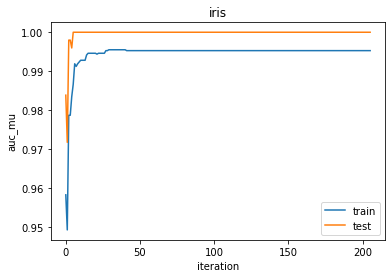

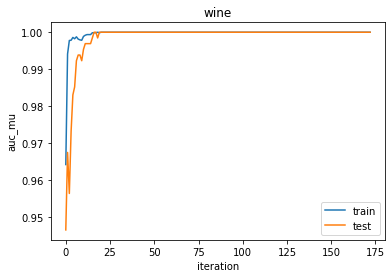

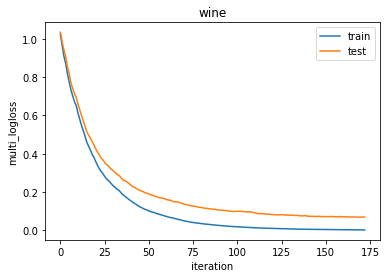

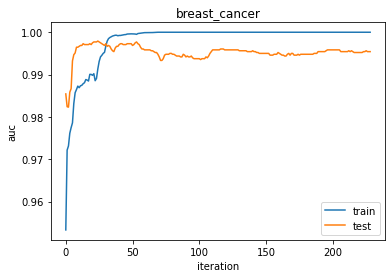

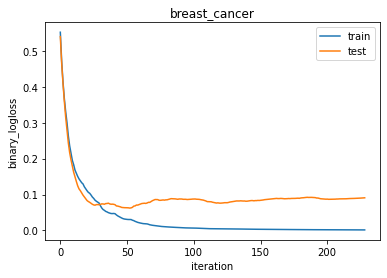

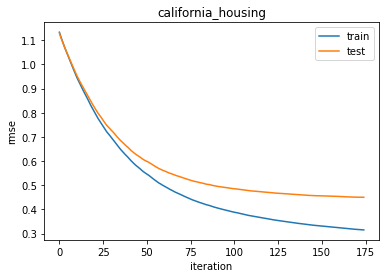

[LightGBM] [Warning] lambda_l1 is set=1.4562643917307401e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4562643917307401e-08
[LightGBM] [Warning] min_gain_to_split is set=1.4206243133229195e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4206243133229195e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.555589144689201e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.555589144689201e-05
[LightGBM] [Warning] feature_fraction is set=0.8206927184168875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8206927184168875
[LightGBM] [Warning] lambda_l2 is set=1.5226625514083211e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5226625514083211e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.8984617865657418, subsample=1.0 will be ignored. Current value: baggin

[LightGBM] [Warning] lambda_l2 is set=1.496445278309383e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.496445278309383e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6650386233297361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650386233297361
[LightGBM] [Warning] lambda_l1 is set=0.05843240728238473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05843240728238473
[LightGBM] [Warning] min_gain_to_split is set=1.9470241586431447e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9470241586431447e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.096681765848783, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.096681765848783
[LightGBM] [Warning] feature_fraction is set=0.5681512988908587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.568

In [11]:
for model, dataset in zip(models_hpo, preprocessed_datasets):
    plot_learning_curve_lgb(model.best_estimator_, dataset['name'])